<a href="https://colab.research.google.com/github/mayumisiano/microeletronica/blob/main/Ind%C3%BAstria_Microeletr%C3%B4nica_An%C3%A1lise_Temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import itertools
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

files.upload()

Saving Analise_Estabelecimentos_3rank_municipio_sp.xlsx to Analise_Estabelecimentos_3rank_municipio_sp.xlsx
Saving Analise_Funcionarios_3rank_estados.xlsx to Analise_Funcionarios_3rank_estados.xlsx
Saving Analise_Funcionarios_3rank_municipio_sp.xlsx to Analise_Funcionarios_3rank_municipio_sp.xlsx
Saving Estabelecimentos_estados.xlsx to Estabelecimentos_estados.xlsx


{'Analise_Estabelecimentos_3rank_municipio_sp.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00b\xee\x9dh^\x01\x00\x00\x90\x04\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

#Análise de Estabelecimentos dos Estados

In [ ]:

xlsx = pd.ExcelFile("Estabelecimentos_estados.xlsx") #busca excel
#pd.set_option('display.max_rows', 100)
sheet_names = xlsx.sheet_names #pega os nomes das planilhas 
df = pd.read_excel(xlsx, sheet_names[0])# abre na primeira planilha
# excluir linha 1, 26, 28 e em diante
df.columns = df.iloc[0].values.tolist() # seta os nomes de colunas para a a primeira linha
df.drop([0,1,26,28,29,30,31,32],inplace=True) #exclui linhas que não precisa
#df.drop([df[28:]],inplace=True)
df.reset_index(drop=True,inplace=True)# reseta o index ja q excluimos linhas
df  = df.transpose() # troca linha com coluna
#df.index = df[['UF']].values.tolist()

df.columns = df.iloc[0].values.tolist() # ajusta o antigo indice q agora é coluna
df.drop('UF',inplace=True) #exclui a linha dos nomes das colunas q sobrou
df = df.sort_index(ascending=True)# organiza os dados pelos anos
df.drop('Total',inplace=True,axis=1) #exclui a coluna total
df


,35 - São Paulo,43 - Rio Grande do Sul,31 - Minas Gerais,41 - Paraná,42 - Santa Catarina,13 - Amazonas,33 - Rio de Janeiro,52 - Goiás,29 - Bahia,26 - Pernambuco,23 - Ceará,25 - Paraíba,51 - Mato Grosso,32 - Espírito Santo,50 - Mato Grosso do Sul,53 - Distrito Federal,17 - Tocantins,21 - Maranhão,24 - Rio Grande do Norte,27 - Alagoas,28 - Sergipe,11 - Rondônia,14 - Roraima,22 - Piauí
2006.0,429,89,91,70,35,46,34,3,9,7,1,2,0,3,2,2,0,2,0,0,0,0,0,0
2007.0,445,97,96,75,40,46,34,5,9,7,1,4,0,2,2,1,0,1,0,0,0,0,0,0
2008.0,476,90,112,79,40,45,34,5,9,7,1,2,0,2,2,0,0,2,0,0,1,0,0,0
2009.0,491,96,123,85,40,40,33,6,8,5,2,6,0,2,1,0,0,1,2,0,0,0,0,1
2010.0,481,104,123,89,43,39,27,11,10,5,2,7,0,1,2,0,0,1,1,0,0,2,1,0
2011.0,486,99,125,92,43,42,21,12,10,4,2,5,0,2,2,1,0,1,1,0,1,0,1,0
2012.0,477,103,131,104,48,40,24,12,14,6,4,5,0,2,2,1,0,2,1,0,2,0,0,0
2013.0,469,108,119,103,48,40,29,15,11,8,5,5,0,2,3,0,0,2,1,0,1,0,0,0
2014.0,456,115,108,89,56,40,23,16,11,8,5,5,0,2,2,2,0,2,1,0,3,0,0,0
2015.0,441,115,107,84,51,36,23,15,9,7,5,5,0,2,1,1,0,1,1,0,4,0,0,0


## Os 3 estados com maiores quantidades de estabelecimentos.

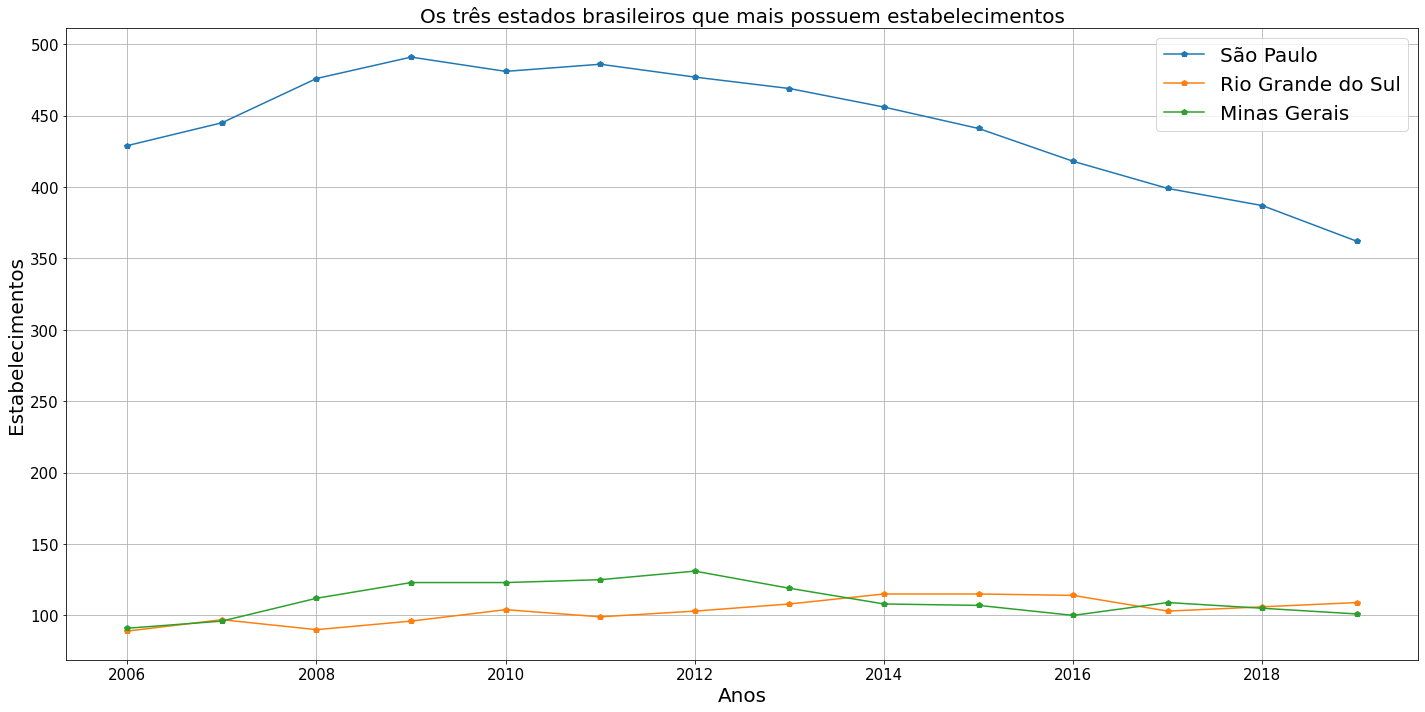

In [ ]:
x = df.index.values # pega os nomes das linhas (anos)

estados = list(df.columns.values) # pega os nomes das colunas

y1 = df[estados[0]].values # valores da primeira coluna
y2 = df[estados[1]].values #            segunda
y3 = df[estados[2]].values #            terceira

y = [y1,y2,y3] # atribuimos nossas series de dados a y 

labels = ["São Paulo", "Rio Grande do Sul","Minas Gerais"]#legenda personalizada

plt.figure(figsize=(20,10)) # tamanho da figura

plt.xlabel('Anos', fontsize=20) # titulo do x e do y
plt.ylabel('Estabelecimentos', fontsize=20)

plt.title("Os três estados brasileiros que mais possuem estabelecimentos", fontsize=20)
plt.tight_layout()
plt.grid(True)

for f,label in zip(y, labels):
  plt.plot(x,f,marker='p',label=label) # desenhamos nossas series


plt.legend() #Atribuimos legenda as series em ordem


##Estabelecimentos de todos os estados

In [ ]:
"""
y=[]
for estado in estados:
  y.append(df[estado].values)
"""

y = df.T.values # as 3 linhas de cima fazem o mesmo
# gira a tabela para que cada elemento de y seja uma array com os valores das 
#colunas e não das linhas

plt.figure(figsize=(20,10))

plt.xlabel('Anos')
plt.ylabel("Estabelecimentos")

for f,estado in zip(y, estados):
  plt.plot(x, f, label=estado, marker='p')
# plota tudo

plt.legend() #legenda tudo


#Analise de Estabelecimentos dos Municipios

In [ ]:
xlsx2= pd.ExcelFile("Analise_Estabelecimentos_3rank_municipio_sp.xlsx")
sheet_names2 = xlsx2.sheet_names 
df2 = pd.read_excel(xlsx2, sheet_names2[0])
df2.columns = df2.iloc[0].values.tolist() 
df2.drop([0,1,26,28,29,30,31,32],inplace=True) 
#df2.drop([df2[28:]],inplace=True)
df2.reset_index(drop=True,inplace=True)
df2 = df2[:-7]

df2  = df2.transpose() 
#df2.index = df2[['UF']].values.tolist()

df2.columns = df2.iloc[0].values.tolist() 
df2.drop('Município-São Paulo',inplace=True) 
#df2 = df2.sort_index(ascending=True)
df2

,Sp-Sao Paulo,Sp-Campinas,Sp-Guarulhos,Sp-Sao Bernardo do Campo,Sp-Sao Jose dos Campos,Sp-Atibaia,Sp-Presidente Prudente,Sp-Bauru,Sp-Cotia,Sp-Sao Caetano do Sul,Sp-Osasco,Sp-Sao Carlos,Sp-Sao Jose do Rio Preto,Sp-Diadema,Sp-Garca,Sp-Indaiatuba,Sp-Sertaozinho,Sp-Taboao da Serra,Sp-Taubate,Sp-Americana,Sp-Araraquara,Sp-Barueri,Sp-Catanduva,Sp-Jaguariuna,Sp-Paulinia,Sp-Sao Roque,Sp-Vinhedo,Sp-Braganca Paulista,Sp-Cacapava,Sp-Guararema,Sp-Hortolandia,Sp-Itu,Sp-Itupeva,Sp-Jundiai,Sp-Leme,Sp-Louveira,Sp-Mogi das Cruzes,Sp-Rio Claro,Sp-Santa Barbara D Oeste,Sp-Santa Cruz das Palmeiras,...,Sp-Alvares Machado,Sp-Aracatuba,Sp-Avare,Sp-Birigui,Sp-Cajamar,Sp-Campo Limpo Paulista,Sp-Cassia dos Coqueiros,Sp-Cosmopolis,Sp-Embu das Artes,Sp-Fernandopolis,Sp-Ferraz de Vasconcelos,Sp-Franco da Rocha,Sp-Guapiacu,Sp-Ipero,Sp-Itaquaquecetuba,Sp-Itatiba,Sp-Jandira,Sp-Jardinopolis,Sp-Juquitiba,Sp-Lencois Paulista,Sp-Lorena,Sp-Marilia,Sp-Matao,Sp-Mineiros do Tiete,Sp-Mirassol,Sp-Mogi Guacu,Sp-Mogi Mirim,Sp-Paraibuna,Sp-Pederneiras,Sp-Penapolis,Sp-Peruibe,Sp-Regente Feijo,Sp-Santana de Parnaiba,Sp-Santo Anastacio,Sp-Santopolis do Aguapei,Sp-Sao Joaquim da Barra,Sp-Sao Sebastiao da Grama,Sp-Sao Vicente,Sp-Sumare,Sp-Tremembe
2019,127,16,10,10,10,8,8,7,7,7,6,6,6,5,5,4,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018.0,144,19,10,9,9,5,9,9,6,8,5,5,8,7,4,4,5,4,4,3,3,4,3,4,2,3,3,1,2,1,1,2,2,4,1,2,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2017.0,162,21,7,9,8,6,7,5,7,7,5,8,7,8,5,4,4,3,4,3,4,4,2,2,3,2,3,1,2,1,0,2,2,3,1,1,3,2,2,0,...,0,0,0,0,0,0,0,0,0,1,1,1,0,1,3,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2016.0,161,20,9,8,8,6,6,6,9,7,5,10,9,9,7,4,4,4,4,4,2,4,2,2,1,4,3,0,2,3,1,2,2,3,0,0,2,3,2,0,...,0,0,0,0,0,0,0,0,1,1,0,1,0,1,3,1,1,0,0,0,0,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,1,1
2015.0,167,24,13,8,11,6,6,6,7,9,5,9,10,9,8,4,4,6,3,5,2,4,3,1,1,4,3,1,2,3,0,3,2,3,0,0,3,3,2,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,2,3,1,1,0,0,0,0,0,2,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1
2014.0,181,20,14,7,12,6,6,8,6,9,5,9,10,8,8,4,4,8,3,5,2,4,4,1,3,4,3,1,2,3,0,3,2,3,0,0,2,2,2,0,...,0,0,0,1,0,0,0,0,2,0,0,1,0,1,3,1,1,0,0,0,0,0,1,1,1,1,1,0,2,1,1,0,1,0,0,0,0,1,1,1
2013.0,191,21,11,7,13,5,6,7,8,7,6,9,8,7,8,4,6,10,3,6,3,4,4,1,2,5,2,1,1,3,0,3,2,3,0,0,3,2,2,0,...,1,0,0,0,0,0,0,1,3,0,1,1,0,1,4,2,1,0,0,0,1,0,1,1,1,1,1,0,2,1,1,0,2,0,0,0,0,0,1,0
2012.0,188,20,13,8,15,4,6,6,12,8,8,10,5,6,9,4,6,10,3,3,3,6,3,2,3,5,2,2,1,3,2,5,2,3,0,0,3,3,2,0,...,1,0,0,1,1,0,0,0,2,0,0,1,0,1,4,3,0,0,0,0,1,0,1,1,1,1,0,0,0,1,1,2,2,0,0,0,0,0,1,0
2011.0,200,20,15,9,21,3,5,5,9,6,5,9,6,7,8,4,4,12,3,3,2,8,3,3,2,4,2,2,1,3,0,4,2,5,0,0,3,3,2,0,...,1,0,0,1,1,0,0,0,0,0,0,1,0,1,3,3,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,1,0
2010.0,194,18,17,10,22,3,7,5,9,4,7,11,3,6,8,6,4,13,3,3,1,6,3,2,0,4,2,2,2,1,1,5,1,6,0,0,2,1,2,0,...,0,0,0,1,1,1,1,0,1,0,0,1,0,1,4,4,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,1,2,0,0,0,0,0,1,0


##Os 3 municipios com maiores quantidades de estabelecimentos de São Paulo

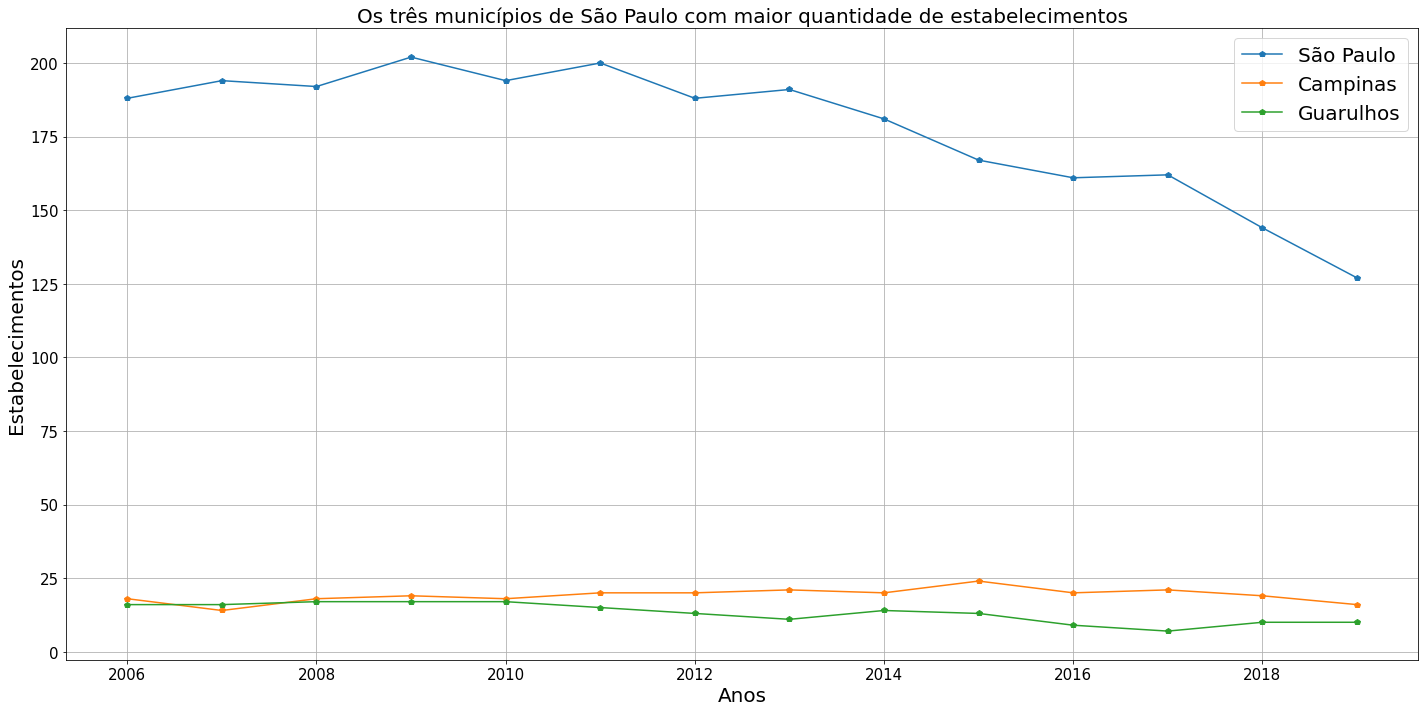

In [ ]:
x = df2.index.values 

municipios = df2.columns.values

y1 = df2[municipios[0]].values
y2 = df2[municipios[1]].values
y3 = df2[municipios[2]].values

labels = ["São Paulo", "Campinas","Guarulhos"]

y = [y1,y2,y3]

plt.figure(figsize=(20,10)) 

plt.xlabel('Anos', fontsize=20) 
plt.ylabel('Estabelecimentos', fontsize=20)

plt.title("Os três municípios de São Paulo com maior quantidade de estabelecimentos", fontsize=20)
plt.tight_layout()
plt.grid(True)

for f, label in zip(y, labels):
  plt.plot(x,f,marker='p',label = label)

plt.legend()



##Todos os Municipios de São Paulo 

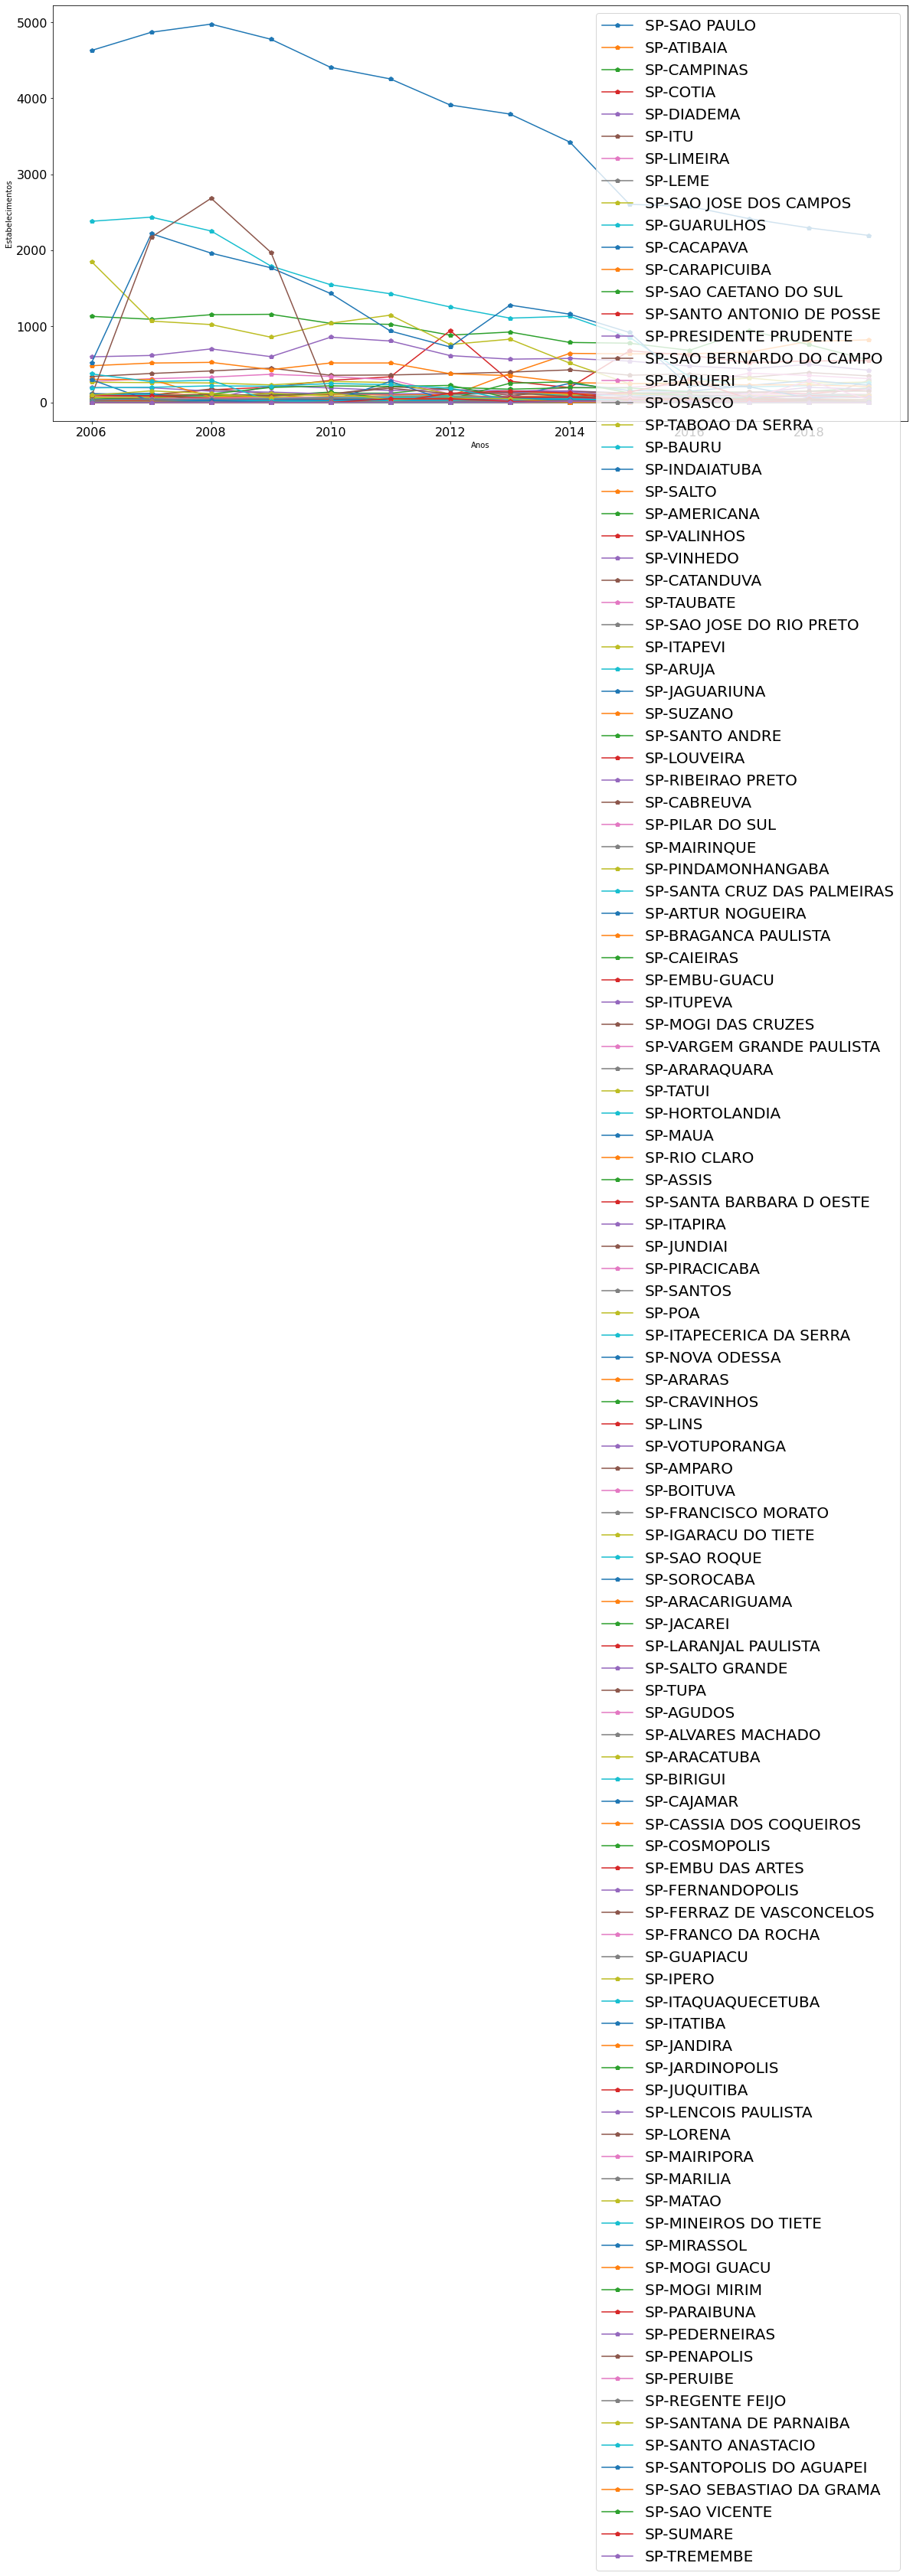

In [ ]:
y = df2.T.values 

plt.figure(figsize=(20,10))

plt.xlabel('Anos')
plt.ylabel("Estabelecimentos")

for f,municipio in zip(y, municipios):
  plt.plot(x, f, label = municipio, marker='p')
# plota tudo

plt.legend() #legenda tudo

#Análise da quantidade de empregados por estado

In [ ]:
xlsx3 = pd.ExcelFile("Analise_Funcionarios_3rank_estados.xlsx") #busca excel
#pd.set_option('display.max_rows', 100)
sheet_names = xlsx3.sheet_names #pega os nomes das planilhas 
df3 = pd.read_excel(xlsx3, sheet_names[0])# abre na primeira planilha
# excluir linha 1, 26, 28 e em diante
df3.columns = df3.iloc[0].values.tolist() # seta os nomes de colunas para a a primeira linha
df3.drop([0,1,26,28,29,30,31,32],inplace=True) #exclui linhas que não precisa
#df3.drop([df[28:]],inplace=True)
df3.reset_index(drop=True,inplace=True)# reseta o index ja q excluimos linhas
df3  = df3.transpose() # troca linha com coluna
#df3.index = df[['UF']].values.tolist()

df3.columns = df3.iloc[0].values.tolist() # ajusta o antigo indice q agora é coluna
df3.drop('UF',inplace=True) #exclui a linha dos nomes das colunas q sobrou
df3 = df3.sort_index(ascending=True)# organiza os dados pelos anos
df3.drop('Total',inplace=True,axis=1) #exclui a coluna total
df3


,35 - São Paulo,13 - Amazonas,31 - Minas Gerais,43 - Rio Grande do Sul,41 - Paraná,33 - Rio de Janeiro,42 - Santa Catarina,29 - Bahia,28 - Sergipe,52 - Goiás,50 - Mato Grosso do Sul,26 - Pernambuco,25 - Paraíba,51 - Mato Grosso,23 - Ceará,32 - Espírito Santo,27 - Alagoas,53 - Distrito Federal,24 - Rio Grande do Norte,21 - Maranhão,17 - Tocantins,11 - Rondônia,14 - Roraima,22 - Piauí
2006.0,16756,8912,2941,3947,2200,782,906,423,0,41,5,224,51,0,44,41,0,11,0,6,0,0,0,0
2007.0,19865,10007,3304,3936,2950,744,898,477,0,24,4,459,82,0,6,41,0,6,0,2,0,0,0,0
2008.0,19830,6947,2417,3871,3808,608,982,432,1,47,42,84,72,0,1,35,0,0,0,3,0,0,0,0
2009.0,17906,7669,2881,4017,3638,527,849,414,0,42,3,80,121,0,3,25,0,0,20,1,0,0,0,9
2010.0,15531,10484,3750,4483,2441,755,968,468,0,70,5,70,129,0,4,1,0,0,6,0,0,25,10,0
2011.0,15050,14730,3979,4149,1878,758,1002,473,1,59,4,80,68,0,6,22,0,0,7,1,0,0,0,0
2012.0,13824,16198,3971,4129,1939,876,1145,423,82,73,2,87,72,0,9,17,0,2,7,8,0,0,0,0
2013.0,13476,19080,3826,4582,1722,753,1148,371,93,105,3,98,8,0,12,13,0,0,13,23,0,0,0,0
2014.0,12799,16494,3923,4562,1489,1014,1077,261,100,163,4,103,25,0,13,10,0,2,16,25,0,0,0,0
2015.0,10846,10578,2777,4476,1311,784,864,231,81,193,2,95,22,0,18,16,0,0,10,0,0,0,0,0


##Os 3 Estados com maior quantidade de empregados

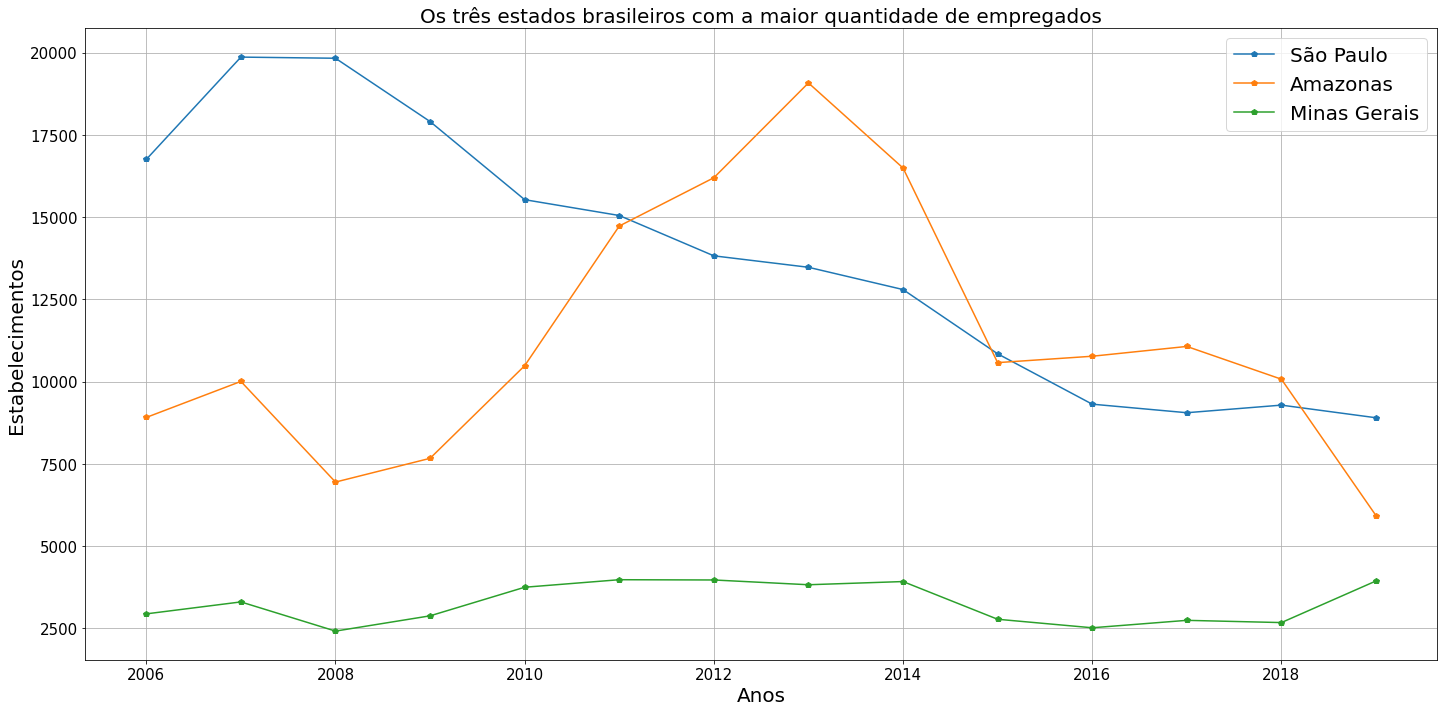

In [ ]:
x = df3.index.values # pega os nomes das linhas (anos)

estados = list(df3.columns.values) # pega os nomes das colunas

y1 = df3[estados[0]].values # valores da primeira coluna
y2 = df3[estados[1]].values #            segunda
y3 = df3[estados[2]].values #            terceira

y = [y1,y2,y3] # atribuimos nossas series de dados a y 

labels = ["São Paulo", "Amazonas","Minas Gerais"]#legenda personalizada

plt.figure(figsize=(20,10)) # tamanho da figura

plt.xlabel('Anos', fontsize=20) # titulo do x e do y
plt.ylabel('Estabelecimentos', fontsize=20)

plt.title("Os três estados brasileiros com a maior quantidade de empregados", fontsize=20)
plt.tight_layout()
plt.grid(True)

for f,label in zip(y, labels):
  plt.plot(x,f,marker='p',label=label) # desenhamos nossas series


plt.legend() #Atribuimos legenda as series em ordem

#Análise da quantidade de empregados por municipio de São Paulo




In [ ]:
xlsx4= pd.ExcelFile("Analise_Funcionarios_3rank_municipio_sp.xlsx")
sheet_names2 = xlsx4.sheet_names 
df4 = pd.read_excel(xlsx4, sheet_names2[0])
df4.columns = df4.iloc[0].values.tolist() 
df4.drop([0,1,26,28,29,30,31,32],inplace=True) 
#df4.drop([df4[28:]],inplace=True)
df4.reset_index(drop=True,inplace=True)
df4 = df4[:-7]

df4  = df4.transpose() 
#df4.index = df4[['UF']].values.tolist()

df4.columns = df4.iloc[0].values.tolist() 
df4.drop('Município-São Paulo',inplace=True) 
#df4 = df4.sort_index(ascending=True)
df4

,SP-SAO PAULO,SP-ATIBAIA,SP-CAMPINAS,SP-COTIA,SP-DIADEMA,SP-ITU,SP-LIMEIRA,SP-LEME,SP-SAO JOSE DOS CAMPOS,SP-GUARULHOS,SP-CACAPAVA,SP-CARAPICUIBA,SP-SAO CAETANO DO SUL,SP-SANTO ANTONIO DE POSSE,SP-PRESIDENTE PRUDENTE,SP-SAO BERNARDO DO CAMPO,SP-BARUERI,SP-OSASCO,SP-TABOAO DA SERRA,SP-BAURU,SP-INDAIATUBA,SP-SALTO,SP-AMERICANA,SP-VALINHOS,SP-VINHEDO,SP-CATANDUVA,SP-TAUBATE,SP-SAO JOSE DO RIO PRETO,SP-ITAPEVI,SP-ARUJA,SP-JAGUARIUNA,SP-SUZANO,SP-SANTO ANDRE,SP-LOUVEIRA,SP-RIBEIRAO PRETO,SP-CABREUVA,SP-PILAR DO SUL,SP-MAIRINQUE,SP-PINDAMONHANGABA,SP-SANTA CRUZ DAS PALMEIRAS,...,SP-TUPA,SP-AGUDOS,SP-ALVARES MACHADO,SP-ARACATUBA,SP-BIRIGUI,SP-CAJAMAR,SP-CASSIA DOS COQUEIROS,SP-COSMOPOLIS,SP-EMBU DAS ARTES,SP-FERNANDOPOLIS,SP-FERRAZ DE VASCONCELOS,SP-FRANCO DA ROCHA,SP-GUAPIACU,SP-IPERO,SP-ITAQUAQUECETUBA,SP-ITATIBA,SP-JANDIRA,SP-JARDINOPOLIS,SP-JUQUITIBA,SP-LENCOIS PAULISTA,SP-LORENA,SP-MAIRIPORA,SP-MARILIA,SP-MATAO,SP-MINEIROS DO TIETE,SP-MIRASSOL,SP-MOGI GUACU,SP-MOGI MIRIM,SP-PARAIBUNA,SP-PEDERNEIRAS,SP-PENAPOLIS,SP-PERUIBE,SP-REGENTE FEIJO,SP-SANTANA DE PARNAIBA,SP-SANTO ANASTACIO,SP-SANTOPOLIS DO AGUAPEI,SP-SAO SEBASTIAO DA GRAMA,SP-SAO VICENTE,SP-SUMARE,SP-TREMEMBE
2019,2197,823,558,549,423,349,313,293,268,260,227,211,190,175,174,149,107,100,98,92,87,86,66,66,65,39,38,37,34,33,33,33,30,27,27,24,24,23,22,21,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018.0,2296,803,760,546,501,393,355,6,254,221,290,232,147,117,198,147,112,108,88,93,59,77,77,91,75,34,284,51,38,34,27,37,27,8,13,25,21,27,7,0,...,1,0,0,0,0,0,0,0,0,0,7,0,0,2,0,0,0,0,0,0,23,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017.0,2417,661,948,524,442,331,384,5,321,204,223,231,134,133,120,135,104,44,89,57,205,76,78,48,81,37,48,48,38,37,10,36,54,5,11,19,21,27,0,0,...,1,6,0,0,0,0,0,0,0,4,5,0,0,3,21,3,0,0,0,0,7,1,0,9,0,0,0,0,0,3,0,0,0,0,0,0,0,0,16,0
2016.0,2579,640,685,621,479,374,239,0,263,338,146,243,139,43,127,126,98,43,93,72,217,97,98,304,87,38,44,65,41,27,11,46,54,0,14,21,23,27,0,0,...,1,3,0,0,0,0,0,0,1,5,0,7,0,4,22,4,2,0,0,0,0,4,0,10,0,5,0,0,0,2,0,0,0,0,0,0,0,0,15,8
2015.0,2606,639,779,679,544,358,201,0,245,857,156,249,191,0,123,124,106,45,103,101,920,110,124,136,78,49,54,64,44,27,1,56,42,0,25,24,21,24,1,0,...,0,0,0,0,0,0,0,0,28,0,0,7,0,6,21,4,1,0,0,0,0,6,0,20,0,7,1,1,0,3,2,1,0,0,0,0,0,13,13,9
2014.0,3425,645,789,195,579,428,195,0,517,1133,252,260,194,0,152,143,121,43,101,87,1161,115,272,72,143,58,64,74,45,27,1,86,59,0,15,31,30,21,1,0,...,1,0,0,0,1,0,0,0,126,0,0,8,0,5,29,5,2,0,0,0,0,3,0,10,12,7,1,2,0,15,5,0,0,1,0,0,0,14,19,14
2013.0,3793,381,926,279,569,399,133,0,832,1109,69,353,174,0,152,94,119,53,126,135,1280,136,253,11,133,64,67,47,55,26,0,80,59,0,3,37,25,20,0,0,...,0,0,2,0,0,0,0,16,151,0,2,10,0,3,32,4,2,0,0,0,0,0,0,12,17,8,1,1,0,10,8,2,0,51,0,0,0,0,15,0
2012.0,3912,86,885,945,616,378,113,0,762,1255,37,377,199,0,169,172,111,110,109,96,729,107,44,37,118,62,76,42,52,31,13,81,224,0,0,52,30,0,41,0,...,2,0,5,0,1,0,0,0,122,0,0,12,0,5,187,36,0,0,0,0,7,0,0,11,19,4,1,0,0,0,5,2,37,56,0,0,0,0,49,0
2011.0,4255,58,1027,337,808,361,94,0,1148,1429,11,519,122,0,157,206,298,46,262,79,939,101,54,30,112,39,66,46,45,38,276,70,211,0,12,44,48,19,73,0,...,4,0,6,0,32,1,0,0,0,0,0,11,0,5,234,36,0,0,0,0,0,0,0,7,22,2,2,0,0,0,4,2,50,38,0,0,0,0,49,0
2010.0,4407,63,1040,290,858,357,44,0,1042,1548,58,519,122,0,190,111,342,132,276,67,1432,102,136,5,112,14,69,26,42,71,22,70,218,0,0,54,37,20,83,0,...,7,0,0,0,25,6,3,0,1,0,0,9,0,6,249,28,0,6,0,0,0,0,0,7,16,3,4,0,0,0,1,0,54,120,0,0,0,0,0,0


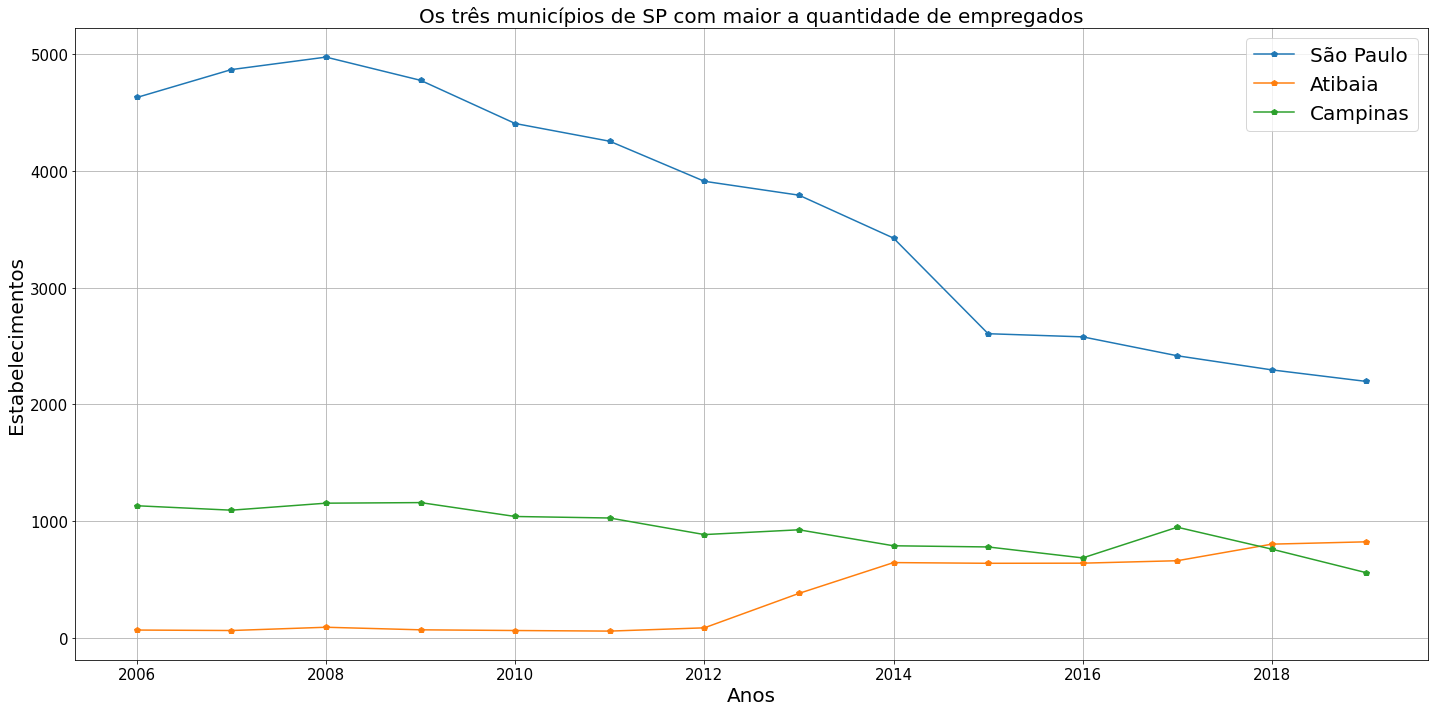

In [ ]:
x = df4.index.values 

municipios = df4.columns.values

y1 = df4[municipios[0]].values
y2 = df4[municipios[1]].values
y3 = df4[municipios[2]].values

labels = ["São Paulo", "Atibaia","Campinas"]

y = [y1,y2,y3]

plt.figure(figsize=(20,10)) 

plt.xlabel('Anos', fontsize=20) 
plt.ylabel('Estabelecimentos', fontsize=20)

plt.title("Os três municípios de SP com maior a quantidade de empregados", fontsize=20)
plt.tight_layout()
plt.grid(True)

for f, label in zip(y, labels):
  plt.plot(x,f,marker='p',label = label)

plt.legend()